# Movie Search Blog
## Part 2: Create Embeddings and Populate OpenSearch
In this section, we will populate an Amazon OpenSearch Service domain with movie indexes. Prior to this step be sure that you have completed the necessary infrastructure prerequistes for Amazon OpenSearch.

We use Neptune ML (https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning.html) Graph Neural Networks (GNN) to encode embeddings for movies in the IMDB dataset. Our goal is to produce a graph-aware vector embedding that represents a movie as well as its related entities, such as genres and artists. 

The movie centric data model we will be working with is seen below:

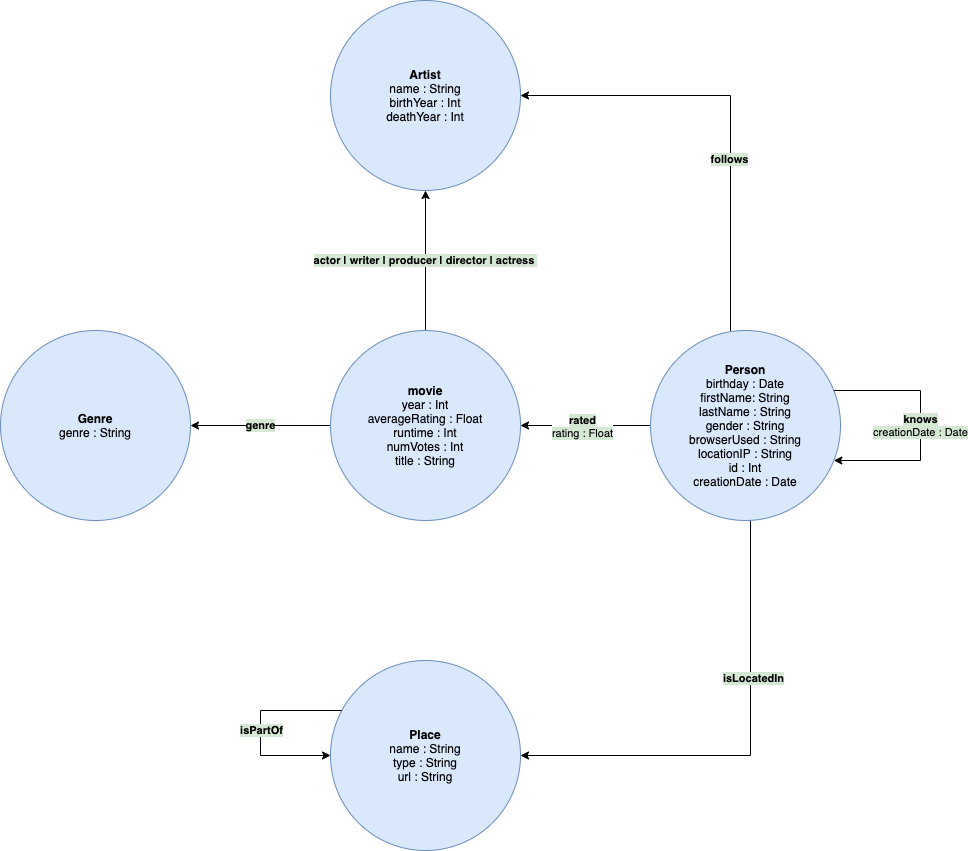

We will only create embeddings for movie, artist, and genre entities. *User and place entities are not included in the embeddings*.

To access the OpenSearch domain, we use methods similar to those seen in the [IMDB Knowledge Graph Blog](https://github.com/aws-samples/imdb-knowledge-graph-blog/blob/main/part3-out-of-catalog/cdk/ooc/lambdas/LoadDataIntoOpenSearchLambda/lambda_handler.py), follow up further there if you are just getting started with Amazon OpenSearch and want to learn more.

The diagram seen below depicts the approach. For a more in depth discussion, refer to our accompanying blog post for more information.

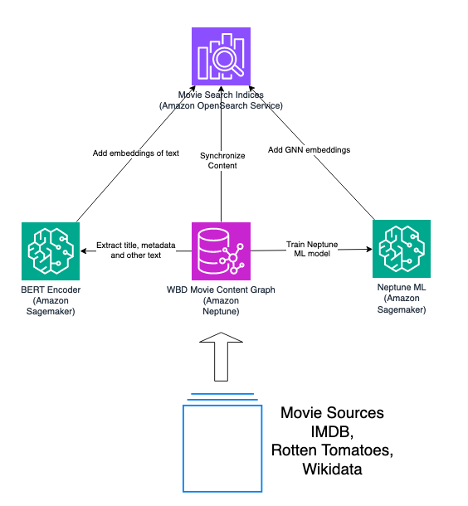


## Settings
First, in the cell below you will need to add in some parameters for your personal enviornment. Be sure to have completed the infrastructure prerequisites before moving on.

In [ ]:
import boto3

REGION = boto3.Session().region_name
SOURCE_S3_PATH_NOSLASH=f"s3://ee-assets-prod-{REGION}/modules/f3f89ef4607743429fb01ae23d983197/v1/workshop/data-v2/imdb-pg"
# Replace the below red string with your S3 bucket will be used to store GNN movie embeddings
TARGET_S3_PATH_NOSLASH="s3://<your bucket>/movie/gnn"
# Replace the below red string with your own Amazon OpenSearch endpoint
AOS_ENDPOINT="<your AOS endpoint>"
# Replace the below red string with your own IAM role for the GNN embedding pipeline.
SAGEMAKER_ROLE="<your IAM role for GNN pipeline>"


## Connect to OpenSearch domain and create indexes


The next step will be connecting to the Amazon OpenSearch domain and creating the indexes over which we will search for the lexical, semantic, and graphical elements of our search process. 

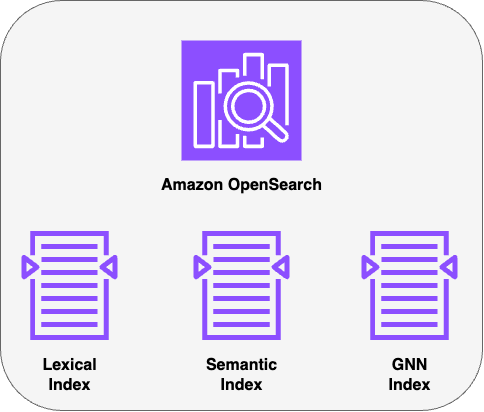

In [ ]:
!pip install -q opensearch-py

In [ ]:
import boto3
from opensearchpy import OpenSearch, RequestsHttpConnection, AWSV4SignerAuth

aos_client = OpenSearch(
    hosts = [{'host': AOS_ENDPOINT.split("//")[1], 'port': 443}],
    use_ssl = True,
    verify_certs = True,
    connection_class = RequestsHttpConnection
)


In [ ]:
aos_client.indices.get_alias(index="*")

The cell below will create the first of 3 OpenSearch indexes, each with different ways for us to conduct similarity search. The first index below will create the lexical based search index.

In [ ]:
movie_index = {
    "settings": {
        "number_of_replicas": 1,
        "number_of_shards": 5,
        "analysis": {
          "analyzer": {
            "default": {
              "type": "standard",
              "stopwords": "_english_"
            }
          }
        }
    },  
    "mappings": {
        "properties": {
            "sentence_embedding": {
                "type": "knn_vector",
                "dimension": 384,  
            },
            "gnn_embedding": {
                "type": "knn_vector",
                "dimension": 64,  
            }
        }
    }
}

aos_client.indices.create(index="movie",body=movie_index)

In [ ]:
aos_client.indices.get(index="movie")

This next cell will create the semantic search index for our search process.

In [ ]:
movie_sentence_index = {
    "settings": {
        "number_of_replicas": 1,
        "number_of_shards": 5,
        "index.knn": True,
        "index.knn.space_type": "cosinesimil",
        "analysis": {
          "analyzer": {
            "default": {
              "type": "standard",
              "stopwords": "_english_"
            }
          }
        }
    },   
    "mappings": {
        "properties": {
            "sentence_embedding": {
                "type": "knn_vector",
                "dimension": 384,  
            },
            "gnn_embedding": {
                "type": "knn_vector",
                "dimension": 64,  
            }
        }
    }
}

aos_client.indices.create(index="movie_sentence",body=movie_sentence_index)

In [ ]:
aos_client.indices.get(index="movie_sentence")

Finally, the following cell will create another search index for our embeddings generated by the GNN. This can also be thought of as our graph intelligent search component.

In [ ]:
movie_gnn_index = {
    "settings": {
        "number_of_replicas": 1,
        "number_of_shards": 5,
        "index.knn": True,
        "index.knn.space_type": "cosinesimil",
        "analysis": {
          "analyzer": {
            "default": {
              "type": "standard",
              "stopwords": "_english_"
            }
          }
        }
    },   
    "mappings": {
        "properties": {
            "sentence_embedding": {
                "type": "knn_vector",
                "dimension": 384,  
            },
            "gnn_embedding": {
                "type": "knn_vector",
                "dimension": 64,  
            }
        }
    }
}

aos_client.indices.create(index="movie_gnn",body=movie_gnn_index)

In [ ]:
aos_client.indices.get(index="movie_gnn")

### Delete index (cleanup only)
Caution, do not run this cell unless you wish to delete your OpenSearch index.

In [ ]:
index_name="<index>"
aos_client.indices.delete(index=index_name)

## Create Sentence Embeddings
In this section we will undergo the process of actually creating the vector embeddings for the sentances in our data.

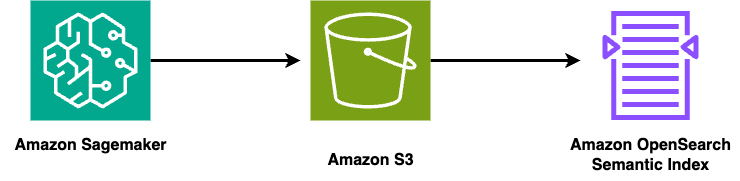
### Get local copy of movie CSV
The first step is pulling a copy of the movie data into the local enivornment as a CSV.

In [ ]:
%%bash -s "$SOURCE_PATH_NOSLASH"

SOURCE_OBJ=$1/movie.consolidated.csv.gz
echo $SOURCE_OBJ
aws s3 cp $SOURCE_OBJ movie.gz
gunzip movie.gz
mv movie movie.csv
wc -l movie.csv

### Setup sentence transformer model

Next we will setup a sentence-transformer model in order to create the embeddings from our natural language text data. For more details on how sentance transformers operate, see this [blog](https://aws.amazon.com/blogs/machine-learning/text-embedding-and-sentence-similarity-retrieval-at-scale-with-amazon-sagemaker-jumpstart/)

In [ ]:
pip install sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

def get_embeddings(sentences):
    embeddings = model.encode(sentences)
    return embeddings
    
def get_str_embedding(embedding):
    return ';'.join([str(x) for x in embedding])

def parse_str_embedding(s):
    toks= s.split(";")
    return list(map(lambda x: float(x), toks))
    


### Generate sentence embeddings for movie, save to local file

The cell below will generate the sentence embeddings from the utilities we imported previously. After generation it will then save these embeddings to a local file within this notebook space.

In [ ]:
import csv

def csv_open(fname, headers):
    ff = []
    ff.append(open(fname, "w"))
    ff.append(csv.writer(ff[0]))
    csv_write(ff, headers)
    return ff

def csv_close(ff):
    ff[0].close()

def csv_write(ff, arr):
    ff[1].writerow("" if pd.isna(a) or a=='-' else a for a in arr)


This takes several hours. 

In [ ]:
import pandas as pd

sentence_embedding_file = csv_open("sentence_embeddings.csv", ["~id", "embedding:vector"])

iter = 0
df= pd.read_csv('movie.csv')
for index, row in df.iterrows():
    iter += 1
    if iter % 500 == 0:
        print(str(iter))
    myrow = [
        row["~id"],
        get_str_embedding(get_embeddings(row["title:string"]))
    ]
    csv_write(sentence_embedding_file, myrow)

csv_close(sentence_embedding_file)

In [ ]:
!head -3 sentence_embeddings.csv

## Create GNN embeddings

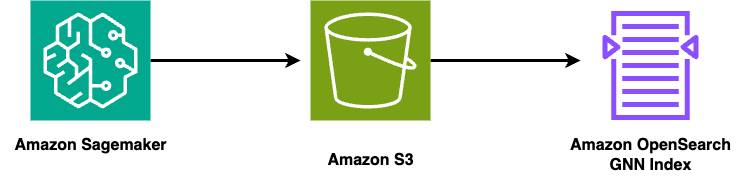

### Stage source data
The next step in the cell below is to generate our "graph aware" GNN embeddings. In order to properly conduct this process your data in a csv format must live within your preconfigured S3 bucket. If you have not already done so be sure to complete the required infrastructre prerequistes before moving on.

In [ ]:
%%bash -s "$SOURCE_S3_PATH_NOSLASH" "$TARGET_S3_PATH_NOSLASH" 

moviefiles=(Artist.consolidated.csv
Genre.consolidated.csv
actor.consolidated.csv
actress.consolidated.csv
director.consolidated.csv
genre.consolidated.csv
movie.consolidated.csv
producer.consolidated.csv
writer.consolidated.csv)

for m in ${moviefiles[@]}
do
    echo $m
    aws s3 cp $1/$m.gz $m.gz
    gunzip $m.gz
    aws s3 cp $m $2/source/$m
    rm $m
done

### Create pipeline for GNN embeddings

The cell below will now create a sagemaker pipeline to generate our embeddings.

In [ ]:
sagemaker_client = boto3.client("sagemaker", region_name=REGION)

sagemaker_client.create_pipeline(
    PipelineName='neptune-ml-sagemaker-pipeline-movie',
    PipelineDefinitionS3Location={
        'Bucket': f"graphlytics-{REGION}",
        'ObjectKey': "v1/sagemaker-pipelines/neptune-ml-training-pipeline.json",
        },
   RoleArn=SAGEMAKER_ROLE
)

### Run and monitor the pipeline to create the GNN embeddings

The cell below will kick off the process to generate the GNN embeddings, this may take some time so do not worry if the response takes awhile.

In [ ]:
input_data_s3_location=f"{TARGET_S3_PATH_NOSLASH}/source"
processed_data_s3_location = f"{TARGET_S3_PATH_NOSLASH}/processing"
train_model_s3_location = f"{TARGET_S3_PATH_NOSLASH}/training"
embedding_s3_location = f"{TARGET_S3_PATH_NOSLASH}/embeddings"
processing_instance_type = "ml.r5.4xlarge"
training_instance_type = "ml.p3.2xlarge"

start_result = sagemaker_client.start_pipeline_execution(
    PipelineName='neptune-ml-sagemaker-pipeline-movie',
    PipelineParameters=[

    { "Name": "inputDataS3Location", "Value": input_data_s3_location },
    { "Name": "processedDataS3Location", "Value": processed_data_s3_location},
    { "Name": "trainModelS3Location", "Value": train_model_s3_location},
    { "Name": "embeddingS3Location", "Value": embedding_s3_location},
    { "Name": "embeddingDimension", "Value": "64"},
    { "Name": "model", "Value": "rgcn"},
    { "Name": "sagemakerIamRoleArn", "Value": SAGEMAKER_ROLE},
    { "Name": "processingInstanceType", "Value": processing_instance_type},
    { "Name": "trainingInstanceType", "Value": training_instance_type}
])

The following cell can be used to monitor the execution of your sagemaker pipeline we just set up. Run the cell to check its current status.

### Monitor the pipeline execution
It takes some time. Get status of the pipeline. PipelineExecutionStatus is most critical attribute. Also view training and processing jobs directly in SageMaker console. 

In [ ]:
arn=start_result['PipelineExecutionArn']

sagemaker_client.describe_pipeline_execution(
    PipelineExecutionArn=arn
)

### Download embeddings

The following cells will download the embeddings we just created into our local enviornment.

In [ ]:
%%bash -s "$TARGET_S3_PATH_NOSLASH" 

echo Download GNN
aws s3 cp $1/embeddings/movie.csv gnn_embeddings.csv



In [ ]:
%%bash

echo need to sort the files by ID allowing us to tie together by row number
head -1 movie.csv > xmovie.csv
head -1 sentence_embeddings.csv > xsentence_embeddings.csv
head -1 gnn_embeddings.csv > xgnn_embeddings.csv

echo movie
tail -n+2 movie.csv | sort >> xmovie.csv
echo sentence
tail -n+2 sentence_embeddings.csv | sort >> xsentence_embeddings.csv
echo gnn
tail -n+2 gnn_embeddings.csv | sort >> xgnn_embeddings.csv

echo confirm num lines the same
wc -l xmovie.csv xgnn_embeddings.csv xsentence_embeddings.csv


In [ ]:
!wc -l xmovie.csv xgnn_embeddings.csv xsentence_embeddings.csv


## Write to indexes

Next, we need to write the embeddings into the OpenSearch indexes which we created at the start of this notebook

In [ ]:
import json

def add_bulk_to_index(index_name, chunk):

    data = []
    for rec in chunk:
        j = {
            'index': {
                '_index': index_name, 
                '_id': rec['id']
            }
        }
        data.append(json.dumps(j))
        data.append(json.dumps(rec['fields']))

    data_to_load = "\n".join(data)
    aos_client.bulk(data_to_load)


In [ ]:
import pandas as pd

CHUNK_SIZE=10000
movie_reader = pd.read_csv('xmovie.csv', iterator=True)
sentence_reader = pd.read_csv('xsentence_embeddings.csv', iterator=True)
gnn_reader = pd.read_csv('xgnn_embeddings.csv', iterator=True)

MOVIE_MAP = {
    'title:string': 'title',
    'year:int': 'year',
    'averageRating:float': 'averageRating',
    'numVotes:int': 'numVotes',
    'runtime:int': 'runtime'
}

def process_next_chunk():
    aos_chunks = []
    movie_df = None
    sentence_df = None
    gnn_df = None
    try:
        movie_df = movie_reader.get_chunk(CHUNK_SIZE)
        sentence_df = sentence_reader.get_chunk(CHUNK_SIZE)
        gnn_df = gnn_reader.get_chunk(CHUNK_SIZE)
        if len(movie_df) == 0:
            return False
    except StopIteration as e: 
        print("Stop")
        print(e)    
        return False
    
    start_index = -1
    for index, row in movie_df.iterrows():
        if start_index == -1:
            start_index = index
            print(start_index)
        aos_rec = {"id": row["~id"], 'fields': {}}
        for m in MOVIE_MAP:
            aos_rec['fields'][MOVIE_MAP[m]]=row[m]
        aos_chunks.append(aos_rec)
    for index, row in sentence_df.iterrows():
        aos_rec = aos_chunks[index-start_index]
        if row['~id']==aos_rec['id']:
            aos_rec['fields']['sentence_embedding']=parse_str_embedding(row['embedding:vector'])
        else:
            raise Exception(f"Sentence Embedding/movie mismatch {str(index)} {str(row)} {str(aos_rec)}")
    for index, row in gnn_df.iterrows():
        aos_rec = aos_chunks[index-start_index]
        if row['~id']==aos_rec['id']:
            aos_rec['fields']['gnn_embedding']=parse_str_embedding(row['embedding:vector'])
        else:
            raise Exception(f"GNN Embedding/movie mismatch {str(index)} {str(row)} {str(aos_rec)}")

    for idx in ['movie', 'movie_sentence', 'movie_gnn']:
        add_bulk_to_index(idx, aos_chunks)
        
    return True

while True:
    ret = process_next_chunk()
    if not ret:
        break



## Try a basic query

Finally, lets test out our hard work with a sample query, here we will input search text for the title "All the Presidents Men".

In [ ]:
num_movies=10
search_text="All the Presidents Men"
query = {
    "size": num_movies,
    "fields": ["title", "year"],
    "query": {"match": {"title": search_text}},
}
lex_result = aos_client.search(index="movie", body=query)

print("Lexical results:")
for idx, h in enumerate(lex_result["hits"]["hits"]):
    print(f"{h['_id']} {h['_score']} {h['_source']['title']} {h['_source']['year']}")

